In [1]:

import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';')
# готовим некоторые данные
data['score_shk'] = data['score_shk'].str.replace(',','.').astype(float)
data['credit_sum'] = data['credit_sum'].str.replace(',','.').astype(float)
# преобразуем указанные переменные в тип object
for i in ['tariff_id', 'open_account_flg']:
    data[i] = data[i].astype('object')
data['living_region'] = data['living_region'].astype(str)
from_replace = ['\s?(ОБЛАСТЬ|ОБЛ\.|ОБЛ|КРАЙ\.|КРАЙ|РЕСПУБЛИКА|РЕСП\.|РЕСП|Г\.\s|Г\s|\sГ|АО|Р-Н)\s?', '74',
                '98|САНКТ-ПЕТЕРБУРГ', 'ЕВРЕЙСКАЯБЛ', 'КАМЧАТСКАЯ|КАМЧАТС\?\?ИЙ', '(МОСКВА|МОСКВОСКАЯ|МЫТИЩИНСКИЙ)',
                '(САХА \(ЯКУТИЯ\)|САХА \/ЯКУТИЯ\/)', 'СЕВ\. ОСЕТИЯ - АЛАНИЯ', 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУ- ЮГРА',
                'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУ- Ю', '(ЧУВАШИЯ\sЧУВАШСКАЯ-|ЧУВАШСКАЯ\s?-\sЧУВАШИЯ)', 'БЛ ЕВРЕЙСКАЯ', 
                'БРЯНСКИЙ', 'ГОРЬКОВСКАЯ', 'ОРЁЛ', 'ПЕРМСКАЯ', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ЭВЕНКИЙСКИЙ', 
                'nan|ГУСЬ-ХРУСТАЛЬНЫЙ|МОСКОВСКИЙ\sП|РОССИЯ', 'ХАНТЫ-МАНСИЙСКИЙ-ЮГРА', 'ЧЕЛЯБИНСК$', 'ЧИТИНСКАЯ',
                'ЧУКОТСКИЙ\sАO', 'Г.МОСКОВСКАЯ', 'Г.ОДИНЦОВО\sМОСКОВСКАЯ', 'ДАЛЬНИЙ\sВОСТОК']
to_replace = ['', 'ЧЕЛЯБИНСКАЯ', 'ЛЕНИНГРАДСКАЯ', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
              'КАМЧАТСКИЙ', 'МОСКОВСКАЯ', 'САХА', 'СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
              'ХАНТЫ-МАНСИЙСКИЙ', 'ХАНТЫ-МАНСИЙСКИЙ', 'ЧУВАШСКАЯ', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
              'БРЯНСКАЯ', 'НИЖЕГОРОДСКАЯ', 'ОРЛОВСКАЯ', 'ПЕРМСКИЙ', 'МОСКОВСКАЯ', 'КРАСНОЯРСКИЙ', 
              'МОСКОВСКАЯ', 'ХАНТЫ-МАНСИЙСКИЙ', 'ЧЕЛЯБИНСКАЯ', 'ЗАБАЙКАЛЬСКИЙ', 'ЧУКОТСКИЙ', 
              'МОСКОВСКАЯ', 'МОСКОВСКАЯ', 'ПРИМОРСКИЙ']
data['living_region'].replace(from_replace, to_replace, regex=True, inplace=True)
    
    
data.at[data['job_position'] == 'PNV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'PNS', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'HSK', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'INV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'ONB', 'job_position'] = 'OTHER'
data.loc[data['tariff_id'].value_counts()[data['tariff_id']].values < 55, 
         'tariff_id'] = '1.99'
    
region_series = data['living_region'].value_counts()
mask = (region_series/region_series.sum() * 100).lt(0.029)
data['living_region'] = np.where(data['living_region'].isin(region_series[mask].index), 
                                 'OTHER', data['living_region'])
data['age'].fillna(data['age'].median(), inplace=True)
for i in ['credit_sum', 'score_shk']:
    data[i].fillna(data[i].median(), inplace=True)
data['monthly_income'].fillna(30000.0, inplace=True)
for i in ['credit_count', 'overdue_credit_count']:
    data[i].fillna(-1, inplace=True)
data['marital_status'] = data['marital_status'].fillna('MAR')
data['education'].fillna(data['education'].value_counts().index[0], inplace=True)
data['tariff'] = data['tariff_id'].astype('float')

In [6]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score

In [8]:
region_encoder = preprocessing.LabelEncoder()
data['living_region'] = region_encoder.fit_transform(list(data['living_region']))

In [9]:
data['living_region'] = data['living_region'].astype('category')

In [10]:
central = ['Белгородская', 'Брянская', 'Владимирская', 'Воронежская', 
         'Ивановская', 'Калужская', 'Костромская', 'Курская', 'Липецкая', 'Московская', 
           'Орловская', 'Рязанская', 'Смоленская', 'Тамбовская', 'Тверская', 'Тульская', 
           'Ярославская', 'Москва']
central = [x.upper() for x in central]

sev_zap = ['Карелия', 'Коми', 'Архангельская', 'Ненецкий', 'Вологодская', 'Калининградская', 
           'Ленинградская', 'Мурманская', 'Новгородская', 'Псковская', 'Санкт-Петербург']
sev_zap = [x.upper() for x in sev_zap]

yug = ['Адыгея', 'Калмыкия', 'Краснодарский', 'Астраханская', 'Волгоградская', 'Ростовская']
yug = [x.upper() for x in yug]

kavkaz = ['Ставропольский', 'Ингушетия', 'Дагестан', 'Чеченская', 'Кабардино-Балкарская', 
 'Карачаево-Черкесская', 'Северная Осетия']
kavkaz = [x.upper() for x in kavkaz]

volga = ['Башкортостан', 'Марий Эл', 'Мордовия', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'Татарстан', 
         'Удмуртская', 'Чувашская', 'Кировская', 'Нижегородская', 'Оренбургская', 'Пензенская', 
         'ПЕРМСКИЙ', 'Самарская', 'Саратовская', 'Ульяновская']
volga = [x.upper() for x in volga]

ural = ['Курганская', 'Свердловская', 'Тюменская', 'Челябинская', 'Ханты-Мансийский', 
        'Ямало-Ненецкий']
ural = [x.upper() for x in ural]

sibir = ['Алтай', 'Бурятия', 'Тыва', 'Хакасия', 'Алтайский', 'Забайкальский', 'Красноярский', 
         'Иркутская', 'Кемеровская', 'Новосибирская', 'Омская', 'Томская']
sibir = [x.upper() for x in sibir]

dvostok = ['Якутия', 'камчатский', 'приморский', 'хабаровский', 'амурская', 
           'магаданская', 'сахалинская', 'еврейская', 'чукотский', 'ДАЛЬНИЙ ВОСТОК']
dvostok = [x.upper() for x in dvostok]

russia = ['РОССИЯ']

In [12]:
data['fed_reg'] = 1
def label_fed_reg(x):
    if x in central:
        return 'central'
    if x in sev_zap:
        return 'sev_zap'
    if x in ural:
        return 'ural'
    if x in yug:
        return 'yug'
    if x in kavkaz:
        return 'kavkaz'
    if x in volga:
        return 'volga'
    if x in sibir:
        return 'sibir'
    if x in dvostok:
        return 'dvostok'
    if x in russia:
        return 'russia'
    else:
        return 'russia'
data['fed_reg'] = data['living_region'].apply(lambda x: label_fed_reg(x))


In [13]:
fo_encoder = preprocessing.LabelEncoder()
data['fed_reg_enc'] = fo_encoder.fit_transform(list(data['fed_reg'])).astype('int')

In [14]:
data['clean_region_freq'] = data.groupby('living_region')['living_region'].transform('count')

In [15]:
data['fed_reg_freq'] = data.groupby('fed_reg')['fed_reg'].transform('count')
data['reg_freq_fed_freq'] = data['clean_region_freq']/data['fed_reg_freq']


In [16]:
data.drop(['clean_region_freq', 'fed_reg_freq', 'living_region', 'fed_reg'], axis=1, inplace=True)

In [17]:
data['credit_divide10000'] = (data['credit_sum'] % 1000 == 0).astype('int')

In [18]:
data['credit_kopeyka'] = data['credit_sum'].astype('str').map(lambda x: int(x[-1]))

In [19]:
data['credit_kopeyka'] = (data['credit_kopeyka'] > 0).astype('int')

In [20]:
data['overdue_ratio'] = data['overdue_credit_count']/data['credit_count']
data['credit_income_ratio'] = data['credit_sum']/data['monthly_income']
data['monthly_payment'] = data['credit_sum']/data['credit_month']

In [21]:
data['overdue_ratio'].fillna(0, inplace=True)

In [22]:
data['monthly_income_sq'] = pow(data['monthly_income'], 2)

In [23]:
data['age_sq'] = pow(data['age'], 2)

In [24]:
data['credit_sum_sq'] = pow(data['credit_sum'], 2)

In [25]:
data.head(2).T

,0,1
client_id,1,2
gender,M,F
age,34,34
marital_status,MAR,MAR
job_position,UMN,UMN
credit_sum,59998,10889
credit_month,10,6
tariff_id,1.6,1.1
score_shk,0.461599,0.461599
education,GRD,SCH


In [27]:
data_dummies = pd.concat([
                        pd.get_dummies(data.gender, prefix = 'sex'),
                        pd.get_dummies(data.marital_status , prefix = 'marital'),
                        pd.get_dummies(data.job_position, prefix = 'job'),
                        pd.get_dummies(data.tariff_id , prefix = 'tariff'),
                        pd.get_dummies(data.education , prefix = 'educ'),
                        pd.get_dummies(data.fed_reg_enc , prefix = 'fed_reg'),
                        pd.get_dummies(data.fed_reg_enc , prefix = 'living_region'),
                        data.age,
                        data.age_sq,
                        data.credit_sum,
                        data.credit_sum_sq,
                        data.credit_month,
                        data.score_shk,
                        data.monthly_income,
                        data.monthly_income_sq,
                        data.credit_count,
                        data.overdue_credit_count,   
                        data.monthly_payment,
                        data.credit_income_ratio,
                        data.overdue_ratio,
                        data.credit_kopeyka,
                        data.credit_divide10000,
                        data.reg_freq_fed_freq], axis=1)

In [28]:
data_dummies.head()

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,monthly_income,monthly_income_sq,credit_count,overdue_credit_count,monthly_payment,credit_income_ratio,overdue_ratio,credit_kopeyka,credit_divide10000,reg_freq_fed_freq
0,0,1,0,0,1,0,0,0,0,0,...,30000.0,900000000.0,1.0,1.0,5999.800000,1.999933,1.0,0,0,0.048932
1,1,0,0,0,1,0,0,0,0,0,...,30000.0,900000000.0,2.0,0.0,1814.833333,0.362967,0.0,0,0,0.130574
2,0,1,0,0,1,0,0,0,0,0,...,30000.0,900000000.0,5.0,0.0,894.000000,0.357600,0.0,0,0,0.013365
3,1,0,0,0,1,0,0,0,0,0,...,30000.0,900000000.0,2.0,0.0,1000.757500,0.400303,0.0,1,0,0.013828
4,0,1,0,0,1,0,0,0,0,0,...,30000.0,900000000.0,1.0,0.0,2122.900000,0.707633,0.0,0,0,0.030191


In [29]:
y = data['open_account_flg']

In [30]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
final_data = scaler.fit_transform(data_dummies)


In [35]:
X_train = pd.DataFrame(final_data, columns=data_dummies.columns).sample(frac=0.7, random_state=200)
X_test = pd.DataFrame(final_data, columns=data_dummies.columns).drop(train.index)

In [ ]:
#X_train = pd.DataFrame(final_data, columns=data_dummies.columns)
#X_test = pd.DataFrame(final_data, columns=data_dummies.columns)

In [36]:
X_train.head()

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,monthly_income,monthly_income_sq,credit_count,overdue_credit_count,monthly_payment,credit_income_ratio,overdue_ratio,credit_kopeyka,credit_divide10000,reg_freq_fed_freq
53397,-1.039723,1.039723,-0.158725,-0.332187,-1.106153,1.508043,-0.144134,-0.128909,-0.183992,-0.027175,...,-0.165241,-0.132248,0.032513,0.03342,0.571975,0.396533,-0.293918,-0.348271,-0.058734,-0.834166
143962,-1.039723,1.039723,-0.158725,-0.332187,-1.106153,1.508043,-0.144134,-0.128909,-0.183992,-0.027175,...,0.194126,-0.029934,0.032513,0.03342,-0.071741,-0.480263,-0.293918,-0.348271,-0.058734,-0.282661
146922,0.961794,-0.961794,-0.158725,-0.332187,0.904034,-0.663111,-0.144134,-0.128909,-0.183992,-0.027175,...,0.393775,0.036731,2.176379,0.03342,-0.509611,0.112412,-0.293918,-0.348271,-0.058734,-0.325006
63697,0.961794,-0.961794,-0.158725,-0.332187,-1.106153,1.508043,-0.144134,-0.128909,-0.183992,-0.027175,...,-0.205171,-0.142213,1.104446,0.03342,-1.203059,-1.383706,-0.293918,-0.348271,-0.058734,-0.888818
54503,-1.039723,1.039723,-0.158725,-0.332187,0.904034,-0.663111,-0.144134,-0.128909,5.435020,-0.027175,...,0.393775,0.036731,0.032513,0.03342,0.749655,-0.042823,-0.293918,-0.348271,-0.058734,-0.203833


In [37]:
from sklearn.decomposition import PCA

In [38]:
final_data

array([[-1.0397234 ,  1.0397234 , -0.15872503, ..., -0.34827132,
        -0.05873427,  0.26503382],
       [ 0.96179426, -0.96179426, -0.15872503, ..., -0.34827132,
        -0.05873427,  2.30753444],
       [-1.0397234 ,  1.0397234 , -0.15872503, ..., -0.34827132,
        -0.05873427, -0.62478729],
       ...,
       [ 0.96179426, -0.96179426, -0.15872503, ...,  2.87132454,
        -0.05873427, -0.76954988],
       [ 0.96179426, -0.96179426, -0.15872503, ..., -0.34827132,
        -0.05873427, -0.82508128],
       [-1.0397234 ,  1.0397234 , -0.15872503, ..., -0.34827132,
        -0.05873427,  2.30753444]])

In [39]:
x = final_data

In [40]:
model = PCA()
results = model.fit(x)

In [41]:

Z = results.transform(x)

In [42]:
Z = results.transform(x) # результат преобразуется в массив для использования вновь созданных данных

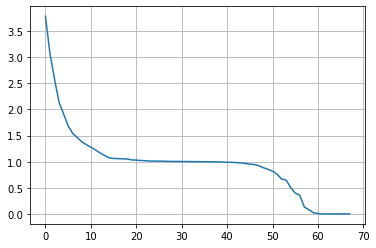

In [43]:
plt.plot(results.explained_variance_)#график каменистой осыпи
plt.grid()
plt.show()

In [44]:
from sklearn.cluster import KMeans,AgglomerativeClustering

In [45]:
model = AgglomerativeClustering(n_clusters=10)

In [65]:
X = model.fit_predict(X_train.iloc[:500, :10])

In [66]:
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [74]:
Sil1 = np.zeros((1,25))
for k in list(range(25))[2:25]:
    Sil1[0][k] = metrics.silhouette_score(X_train.iloc[:500, :10], AgglomerativeClustering(n_clusters=k).fit_predict(X_train.iloc[:500, :10]), metric='euclidean')  

In [70]:
Sil1

array([[0.        , 0.        , 0.90380666, 0.38946452, 0.45840285,
        0.49963883, 0.64893033, 0.74240397, 0.77099955, 0.79378743,
        0.93866557, 0.97157342, 0.97593862, 0.97686681, 0.97839211,
        0.98308222, 0.98647294, 0.99183594, 0.9913739 , 0.992     ,
        0.972     ]])

In [71]:
model_Kmeans = KMeans(n_clusters = 10,n_init = 2000)

In [72]:
X_KMeans = model_Kmeans.fit_predict(X_train.iloc[:500, :10])

In [ ]:
Sil2 = np.zeros((1,30))
for k in list(range(30))[2:30]:
    Sil2[0][k] = metrics.silhouette_score(X_train.iloc[:500, :10], KMeans(n_clusters = k,n_init = 200).fit_predict(X_train.iloc[:500, :10]), metric='euclidean') 
print(Sil2)